In [ ]:
from fastai import *
from fastai.text import *
import spacy
from spacy.symbols import ORTH
import string

In [ ]:
! pip install -q transformers

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'xxxemoji', text)

def remove_all_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

def remove_hashtag(text):
    hasht=re.compile(r'#')
    return hasht.sub('xxxhash_',text)

def remove_underscore(text):
    at=re.compile('_')
    return ' '.join(at.split(text))

def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'xxxuser',text)

def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'_xxxnumber_', text)

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'xxxurl',text)

def remove_repeat_punct(text):
    def _replace_rep_punct(m):
        c,cc = m.groups()
        return f' xxxrepeat {c}' 
    rep = re.compile(r'([!?.])(\1{2,})')
    return rep.sub(_replace_rep_punct, text)

def remove_elongated_words(text):
    rep = re.compile(r'\b(\S*?)([a-z])\2{2,}\b')
    return rep.sub(r'\1\2 xxxelong', text)


def remove_not_ASCII(text):
     text = ''.join([word for word in text if word in string.printable])
     return text


def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'xxxsmile', text)


def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'xxxsadface', text)

def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'xxxheart', text)

def clean_tweet(text):

    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)

    # Lower text, replace abbreviations
    text = text.lower()
    # text = replace_abbrev(text)
    text = remove_mention(text)
    text = remove_hashtag(text)
    text = remove_number(text)
    text=  remove_underscore(text)


    # Remove emojis / smileys
    text = remove_emoji(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
    text = remove_repeat_punct(text)
    text = remove_all_punct(text)
    text = remove_elongated_words(text)



    return text


In [ ]:
spl_token_list=['xxxurl','xxxuser','xxxhash','xxxnumber','xxxemoji','xxxsmile','xxxsadface','xxxheart','xxxelong','xxxrepeat']

In [ ]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False


In [ ]:
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig


In [ ]:
MODEL_CLASSES = {
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig)
}

In [ ]:
seed = 42
use_fp16 = False
bs = 16

model_type = 'roberta'
pretrained_model_name='roberta-base'

In [ ]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [ ]:
transformer_tokenizer=tokenizer_class.from_pretrained(pretrained_model_name)
transformer_tokenizer.add_special_tokens({'additional_special_tokens':spl_token_list})

10

In [ ]:
class TransformerBaseTokenizer(BaseTokenizer):
  def __init__(self,pretrained_tokenizer,model_type='roberta',**kwargs):
    self._pretrained_tokenizer=pretrained_tokenizer
    self.model_type=model_type
    self.max_seq_len=pretrained_tokenizer.max_len
  def __call__(self,*args,**kwargs):
    return self
  def __name__(self,*args,**kwargs):
    return "TranformerBaseTokenizer!"
  def tokenizer(self,t):
    CLS=self._pretrained_tokenizer.cls_token
    SEP=self._pretrained_tokenizer.sep_token
    tokens=self._pretrained_tokenizer.tokenize(t,add_prefix_space=True,)[:self.max_seq_len-2]
    tokens=[CLS] + tokens + [SEP] 
    return tokens

In [ ]:
transformer_base_tokenizer = TransformerBaseTokenizer(pretrained_tokenizer=transformer_tokenizer,model_type=model_type)
fastai_tokenizer = Tokenizer(transformer_base_tokenizer,pre_rules=[fix_html],post_rules=[])

In [ ]:
class TransformerVocab(Vocab):
  def __init__(self,tokenizer:PreTrainedTokenizer):
    super(TransformerVocab,self).__init__(itos=[])
    self._tokenizer=tokenizer

  def numericalize(self,t):
    return self._tokenizer.convert_tokens_to_ids(t)

  def textify(self,nums,sep=' '):
    nums=np.array(nums).tolist()
    return sep.join(self._tokenizer.convert_ids_to_tokens(nums)) if sep is not None else  self._tokenizer.convert_ids_to_tokens(nums)

  def __getstate__(self):
    return {'itos':self.itos,'tokenizer':self._tokenizer}

  def __setstate__(self,state):
    self.itos=state['itos']
    self._tokenizer=state['tokenizer']
    self.stoi=collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)}) 
    return

In [ ]:
transformer_vocab=TransformerVocab(tokenizer=transformer_tokenizer)
numericalize_processor=NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor=TokenizeProcessor(tokenizer=fastai_tokenizer,include_bos=False,include_eos=False)

transformer_processor= [tokenize_processor,numericalize_processor]

In [ ]:
pad_idx=transformer_tokenizer.pad_token_id

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
! mkdir  ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [ ]:
base_dir='/content/drive/My Drive/Colab Notebooks/Sentiment140'
root =Path(base_dir)
root.mkdir(parents=True,exist_ok=True)

data_dir=Path(root/'data')
data_dir.mkdir(parents=True,exist_ok=True)

model_dir=Path(root/'models')
model_dir.mkdir(parents=True,exist_ok=True)

In [ ]:
! unzip -q -n sentiment140.zip

unzip:  cannot find or open sentiment140.zip, sentiment140.zip.zip or sentiment140.zip.ZIP.


In [ ]:
train=pd.read_csv('training140.csv',encoding='ISO-8859-1',names=["target", "ids", "date", "flag", "user", "text"])

In [ ]:
train.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
train.to_csv(data_dir/'train140.csv',index=False)

In [ ]:
train=pd.read_csv(data_dir/'train140.csv')

In [ ]:
train.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
train=train.drop(['date','flag','user'],axis=1)

In [ ]:
train['text']=train['text'].apply(clean_tweet)

In [ ]:
def decode_sentiment(x):
  if(x==0):
    return "NEG"
  else :
    return "POS"

In [ ]:
train['target']=train['target'].apply(decode_sentiment)

In [ ]:
train['target'].unique()

array(['NEG', 'POS'], dtype=object)

In [ ]:
train.to_csv(data_dir/'train_cleaned.csv',index=False)

In [ ]:
train=pd.read_csv(data_dir/'train_cleaned.csv')

In [ ]:
train.head()

,target,ids,text
0,NEG,1467810369,xxxuser xxxurl aw xxxelong thats a bummer yo...
1,NEG,1467810672,is upset that he cant update his facebook by t...
2,NEG,1467810917,xxxuser i dived many times for the ball manage...
3,NEG,1467811184,my whole body feels itchy and like its on fire
4,NEG,1467811193,xxxuser no its not behaving at all im mad why ...


In [ ]:
tdummy=train.iloc[1:100]

In [ ]:
tdummy.to_csv(data_dir/'traind.csv',index=False)

In [ ]:
data=TextList.from_df(train,cols='text',processor=transformer_processor).split_by_rand_pct(0.1,seed=42).label_from_df(cols='target').databunch(pad_first=False,pad_idx=pad_idx)

In [ ]:
data.show_batch()

text,target
<s> Ġhi xxxnumber Ġd p xxxnumber Ġar xxxnumber Ġof xxxnumber Ġmm xxxnumber Ġor xxxnumber Ġar xxxnumber Ġac xxxnumber Ġm Ġhi xxxnumber Ġof xxxnumber Ġr r xxxnumber Ġof xxxnumber Ġv d xxxnumber Ġbi xxxnumber Ġmm xxxnumber Ġhi xxxnumber Ġof xxxnumber Ġr r xxxnumber Ġof xxxnumber Ġv d xxxnumber Ġj r xxxnumber Ġpg xxxnumber Ġmm xxxnumber Ġhi xxxnumber Ġof xxxnumber Ġr r xxxnumber Ġof xxxnumber Ġv d xxxnumber Ġf c xxxnumber Ġhr,NEG
<s> xxxuser Ġmer a Ġa ad ha Ġya Ġth ak ur Ġor Ġg ab bar Ġke Ġa ad ha Ġye h Ġlog Ġtho Ġmuc he Ġba at ne Ġka Ġplan Ġk ar Ġra he Ġha in Ġaur Ġth um Ġmu je Ġdh oke ba az Ġke h Ġra he Ġho </s>,NEG
<s> xxxhash Ġfren chie b day xxxhash Ġfren chie b day xxxhash Ġfren chie b day xxxhash Ġfren chie b day xxxhash Ġfren chie b day xxxhash Ġfren chie b day xxxhash Ġfren chie b day xxxhash Ġfren chie b day xxxhash Ġfren chie b day </s>,POS
<s> xxxhash Ġdel ong eday xxxhash Ġdel ong eday xxxhash Ġdel ong eday xxxhash Ġdel ong eday xxxhash Ġdel ong eday xxxhash Ġdel ong eday xxxhash Ġdel ong eday xxxhash Ġdel ong eday xxxhash Ġdel ong eday xxxhash Ġdel ong eday xxxhash Ġdel ong eday </s>,POS
<s> Ġth t Ġbc Ġm n h Ġk hi Ġn gi Ġl n Ġc Ġn gh Ġcon Ġn t Ġxen Ġvo Ġch u yn Ġca Ġh Ġn h ng Ġh Ġcha Ġb ao Ġh Ġn gh Ġthe o Ġch iu Ġh ng Ġng c Ġli </s>,NEG


In [ ]:
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

In [ ]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 2
config.use_bfloat16 = False
print(config)

RobertaConfig {
  "_num_labels": 2,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": 0,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 514,
  "min_length": 0,
  "model_type": "roberta",
  "no_repeat_ngram_size": 0,
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_layers": 12,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 1,
  

In [ ]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
transformer_model.resize_token_embeddings(len(transformer_tokenizer))
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

In [ ]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(data,
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

In [ ]:
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [ ]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 14 groups
[Sequential(
  (0): Embedding(50275, 768)
  (1): Embedding(514, 768, padding_idx=1)
  (2): Embedding(1, 768)
  (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_fea

In [ ]:
learner.freeze_to(-1)

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 9.12E-08


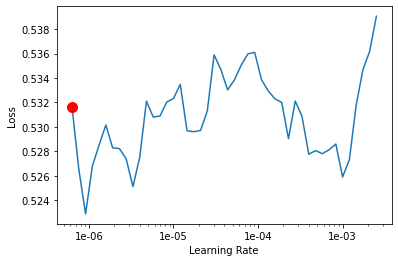

In [ ]:
learner.recorder.plot(skip_end=15,suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.535475,0.473116,0.781462,0.218537,34:17
1,0.520604,0.477608,0.776619,0.223381,34:22
2,0.518899,0.470153,0.782238,0.217763,34:22
3,0.531638,0.469661,0.783037,0.216963,34:18
4,0.522933,0.468967,0.783156,0.216844,34:23


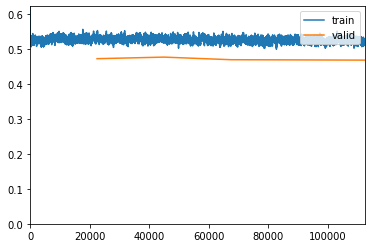

In [ ]:
learner.fit_one_cycle(5,1e-04,moms=(0.8,0.7))

In [ ]:
learner.freeze_to(-2)

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


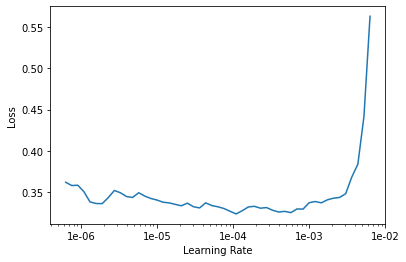

In [ ]:
learner.recorder.plot(skip_ends=55)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.357571,0.343917,0.848562,0.151438,19:37
1,0.320065,0.344663,0.850012,0.149988,19:38


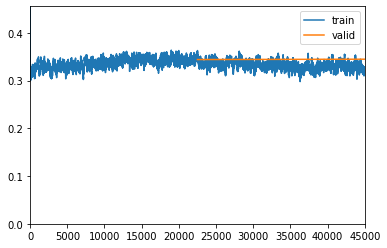

In [ ]:
learner.fit_one_cycle(2,slice(1e-05,1e-04),moms=(0.8,0.7))

In [ ]:
learner.save(model_dir/'bert-3')

In [ ]:
learner.load(model_dir/'bert-3')

Learner(data=TextClasDataBunch;

Train: LabelList (1440000 items)
x: TextList
<s> xxxuser xxxurl Ġaw xxxelong Ġthats Ġa Ġb ummer Ġyou Ġshould a Ġgot Ġdavid Ġcar r Ġof Ġthird Ġday Ġto Ġdo Ġit xxxsmile </s>,<s> Ġis Ġupset Ġthat Ġhe Ġcant Ġupdate Ġhis Ġfacebook Ġby Ġtexting Ġit xxxrepeat Ġand Ġmight Ġcry Ġas Ġa Ġresult Ġschool Ġtoday Ġalso Ġblah </s>,<s> xxxuser Ġi Ġd ived Ġmany Ġtimes Ġfor Ġthe Ġball Ġmanaged Ġto Ġsave xxxnumber Ġthe Ġrest Ġgo Ġout Ġof Ġbounds </s>,<s> Ġmy Ġwhole Ġbody Ġfeels Ġit chy Ġand Ġlike Ġits Ġon Ġfire </s>,<s> xxxuser Ġno Ġits Ġnot Ġbehaving Ġat Ġall Ġim Ġmad Ġwhy Ġam Ġi Ġhere Ġbecause Ġi Ġcant Ġsee Ġyou Ġall Ġover Ġthere </s>
y: CategoryList
NEG,NEG,NEG,NEG,NEG
Path: .;

Valid: LabelList (160000 items)
x: TextList
<s> xxxuser Ġah xxxelong Ġi Ġhope Ġyour Ġok xxxrepeat </s>,<s> xxxuser Ġcool Ġi Ġhave Ġno Ġtweet Ġapps Ġfor Ġmy Ġr az r xxxnumber </s>,<s> xxxuser Ġi Ġknow Ġjust Ġfamily Ġdrama Ġits Ġlame hey Ġnext Ġtime Ġu Ġhang Ġout Ġwith Ġk im Ġn Ġu Ġguys Ġlike Ġhav

In [ ]:
learner.freeze_to(-3)

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


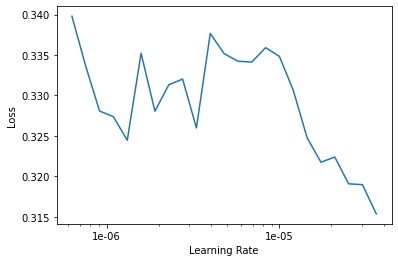

In [ ]:
learner.recorder.plot(skip_end=30)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.324028,0.342740,0.851769,0.148231,24:40


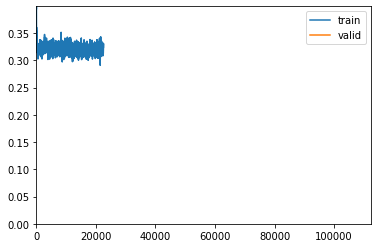

Buffered data was truncated after reaching the output size limit.

In [ ]:
learner.fit_one_cycle(5,2e-05,moms=(0.8,0.7))

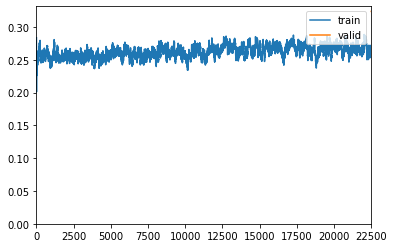

[0.33139345, tensor(0.8652), tensor(0.1347)]

In [ ]:
learner.validate(data.valid_dl)

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


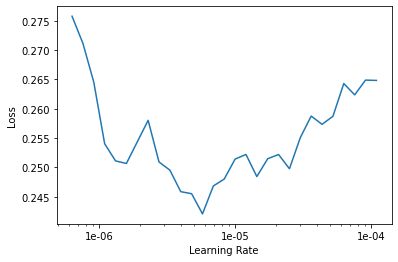

In [ ]:
learner.recorder.plot(skip_end=25)

In [ ]:
learner.fit_one_cycle(2,5e-06,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time


Buffered data was truncated after reaching the output size limit.

In [ ]:
learner.export(model_dir/'transformer2.pkl')